In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from pandas.io.json import json_normalize #package for flattening json in pandas df
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import category_encoders as ce
import glob
import re
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import base
from sklearn.model_selection import KFold
import os
from sklearn.preprocessing import StandardScaler

%matplotlib inline



Using TensorFlow backend.


In [2]:
df_pet = pd.read_csv("../input/train/train.csv")
df_pet.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [3]:
df_pet.shape

(14993, 24)

In [4]:
df_pet.dtypes

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object

<H1>Exploratory Data Analysis</H1>

In [5]:
df_pet.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


<H2>Imbalance Dataset</H2>
First of all, the dataset is imbalaced.  There is only 2.7% of AdoptionSpeed = 0 (adopted on the same day it was listed).

In [6]:
df_pet.groupby('AdoptionSpeed')['AdoptionSpeed'].count()

AdoptionSpeed
0     410
1    3090
2    4037
3    3259
4    4197
Name: AdoptionSpeed, dtype: int64

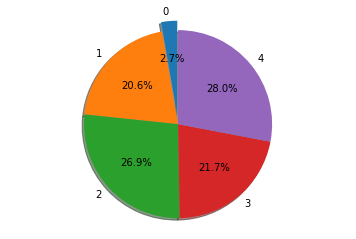

In [7]:
labels = '0', '1', '2', '3', '4'
sizes = df_pet.groupby('AdoptionSpeed')['AdoptionSpeed'].count()
explode = (0.1, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<H3>Breed</H3>

<H2>Incorrect/Insufficient Data</H2>
When we do a query on the breed of the pets (as shown below), we noticed that there are 5927 pets with BreedId 307 (Mixed Breed) and 5 with BreedId 0 (Not available).<br>
Firstly, there are no Breed 0 in the breed lookup table.  That means the breed of the pet is not available.  <br>
Secondly, breed 307 means Mixed Breed in the lookup table.  That means the owner might not know the correct breed of the pets except that they know it is a mixed breed.  <br>
For pets with these 2 kind of breeds, we might be able to gather more information about the correct breeds from the images of the pets.  These could be obtained from the metadata of the images which has been preprossed using Google Vision API<br>  

In [8]:
df_pet[(df_pet['Breed1'] == 0) | (df_pet['Breed1'] == 307)].groupby('Breed1')['Breed1'].count()

Breed1
0         5
307    5927
Name: Breed1, dtype: int64

Next, we do not want to include feature that have less than or equal to 5 records.  This is because the data is either incorrect or it is too specific which will affect how the machine learning algorithm learns.  These records will be removed in the 'Cleaning Data' section.  However, these numbers might change after we gather the correct breed from the pet images.

In [9]:
df_pet.groupby(['Breed1', 'Breed2']).filter(lambda x: len(x) <= 5)['Breed1'].count()

1059

The bar chart below shows the top 10 breed for dogs based on each adoption speed.

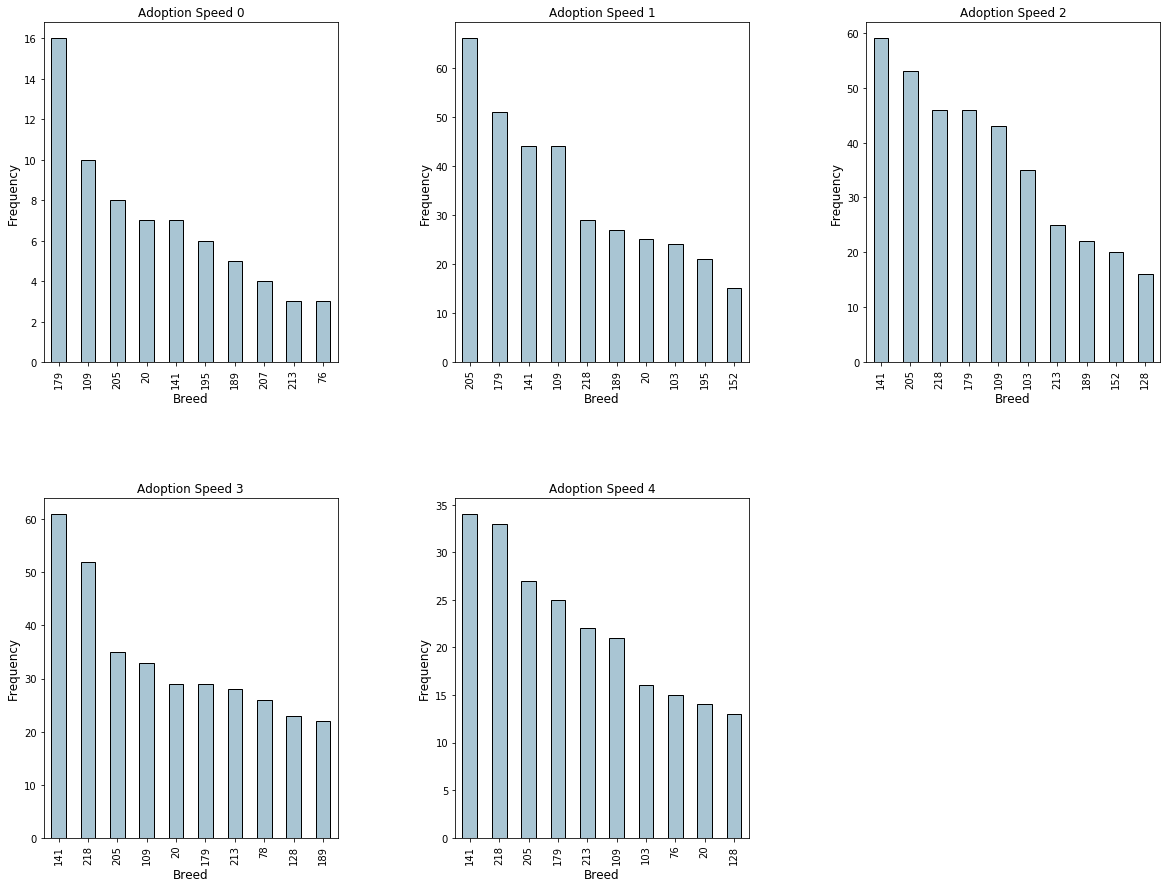

In [10]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(20)
for i in range(1, 6):
    ax = fig.add_subplot(2, 3, i)
    ax = df_pet[(df_pet['AdoptionSpeed'] == i-1) & (df_pet['Type'] == 1) & (df_pet['Breed1'] != 307)].groupby('Breed1')['PetID'].count().sort_values(ascending=False).head(10).plot.bar(color='#A9C5D3', edgecolor='black',  
                          grid=False)
    ax.set_title('Adoption Speed {}'.format(i-1))
    ax.set_xlabel('Breed', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)


<H3>Age</H3>

Text(0, 0.5, 'Frequency')

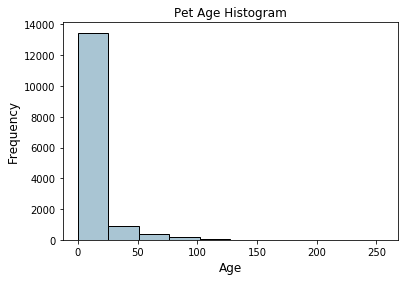

In [11]:
fig, ax = plt.subplots()
df_pet['Age'].hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)
ax.set_title('Pet Age Histogram', fontsize=12)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

From the histogram above, we can see that the age distribution is not very good.  Therefore, we might want to remove age that has less or equal to 5 records.

In [12]:
df_pet.groupby("Age").filter(lambda x: len(x) <= 5)['Age'].count()

106

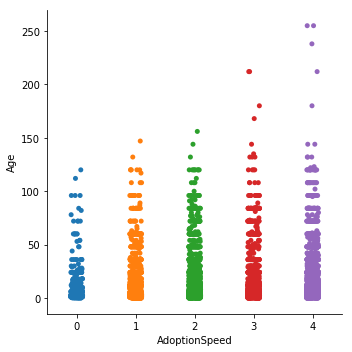

In [13]:
sns.catplot(x="AdoptionSpeed", y="Age", data=df_pet)

<H3>Color</H3>

Same goes color feature where any color combination that has less or equal to 5 records will be removed.

In [14]:
df_pet.groupby(['Color1', 'Color2', 'Color3']).filter(lambda x: len(x) <= 5)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
1787,2,Novi,1,266,0,1,3,4,6,2,2,2,2,2,1,1,0,41326,3f50f2f416e698600bc9d3c1accf5a9e,0,abandoned kitten found in neighbourhood cute w...,fe5bc83d2,3.0,3
4531,2,3 Little Kitten,1,266,0,3,3,4,6,1,1,1,1,2,1,3,0,41326,29d21c8d73c1c4f10395242553a61a7c,0,These 3 kittens were born at my house. Their m...,3338e5ec6,5.0,3
6925,2,Young Kittens,1,266,0,3,3,4,6,2,1,2,2,2,1,4,0,41401,6ac4171715e5fc1d69131b86a9bec346,0,4 young kittens for adoption. Mix gender. I'm ...,a6278a50c,7.0,2
7124,2,NaN,36,285,0,1,3,4,6,2,2,3,3,3,1,1,0,41401,22d9e67d412f25866e09f2c098a6ebef,0,"Hi guys , i found some abandon dogs and cats i...",1cd5acd7a,4.0,1
7953,2,Looking For A Kitten,4,251,292,1,3,4,6,2,2,1,1,2,1,1,0,41326,63900573e92222eef82b39d0ce28ce17,0,"Hi, I am looking for a Little kitten to adopt ...",10400a0b8,0.0,2


<H3>Maturity Size</H3>
Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)<br>
When maturity size is 0 (Not Specified), meaning this does not give any information to our analysis, which should be removed.<br>
However, nothing need to be done here as there are no Maturity Size 0 in the dataset.

In [15]:
df_pet[df_pet['MaturitySize'] == 0]['MaturitySize'].count()

0

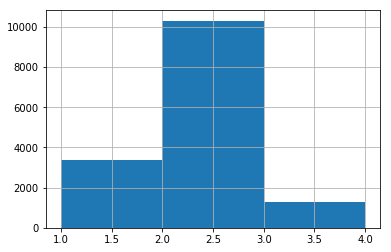

In [16]:
df_pet['MaturitySize'].hist(bins=3)

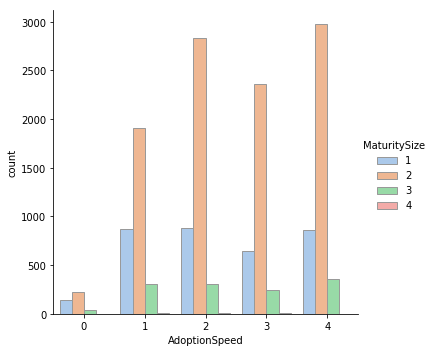

In [17]:
sns.catplot(x="AdoptionSpeed", hue="MaturitySize", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_pet)

From the chart above, we could see that most of the pets have maturity size 2 (Medium)

<H3>Fur Length</H3>
Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)<br>
When fur length is 0 (Not Specified), meaning this does not give any information to our analysis, which should be removed.<br>
However, nothing need to be done here as there are no Fur Length 0 in the dataset.

In [18]:
df_pet[df_pet['FurLength'] == 0]['FurLength'].count()

0

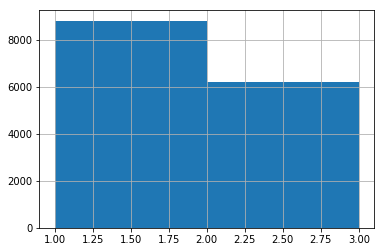

In [19]:
df_pet['FurLength'].hist(bins=2)

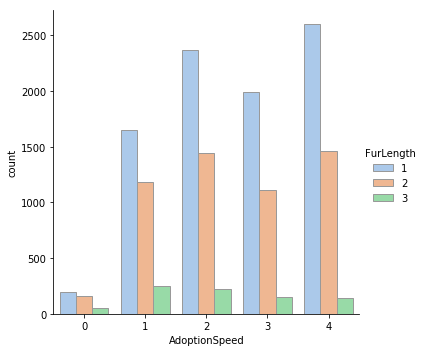

In [20]:
sns.catplot(x="AdoptionSpeed", hue="FurLength", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_pet)

<H3>Health</H3>
Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)<br>
When Health is 0 (Not Specified), meaning this does not give any information to our analysis, which should be removed.<br>
However, nothing need to be done here as there are no Health 0 in the dataset.

In [21]:
df_pet[df_pet['Health'] == 0]['Health'].count()

0

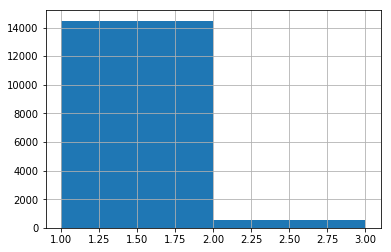

In [22]:
df_pet['Health'].hist(bins=2)

In [23]:
df_pet['Health'].value_counts()

1    14478
2      481
3       34
Name: Health, dtype: int64

<H3>Fee</H3>
Fee should not be selected as a feature.  Out of 14993 samples, 12663 are free of charge.  This means 85% of the samples have fee = 0.  Besides, many other fee values are very specific like one case that have fee $ 3000, one case has fee $ 2000, etc.  Therefore, fee is not a good feature for our model and should be elimited our feature selection.

In [24]:
df_pet[df_pet['Fee'] == 0]['Fee'].count()

12663

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


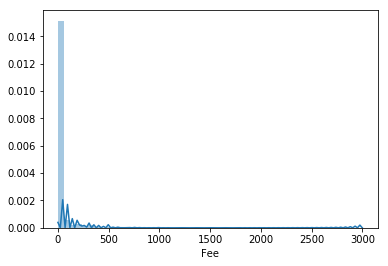

In [25]:
sns.distplot(df_pet['Fee'])

<H3>Photo Amt</H3>

In [26]:
df_pet.groupby("PhotoAmt").filter(lambda x: len(x) <= 5)['PhotoAmt'].count()

0

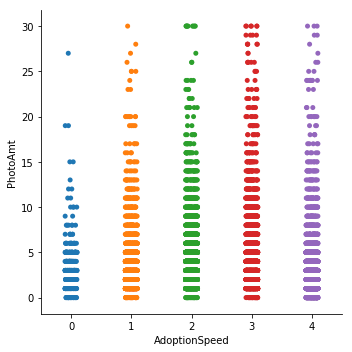

In [27]:
sns.catplot(x="AdoptionSpeed", y="PhotoAmt", data=df_pet)

<H3>Quantity</H3>

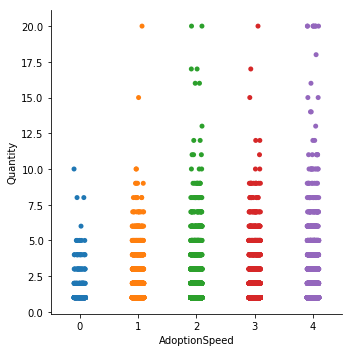

In [28]:
sns.catplot(x="AdoptionSpeed", y="Quantity", data=df_pet)

<H1>Cleaning Data</H1>

In [29]:
def clean_data(df):
    print('cleaning data..')
    # Remove data without primary breed (Breed1 == 0)
    #df_cleaned = df[df['Breed1'] > 0]
    
    # Remove age that has less than or equal to 5 records 
    age_remove_index = df.groupby("Age").filter(lambda x: len(x) <= 5).index.values
    if len(age_remove_index) > 0:
        df.drop(labels=age_remove_index, inplace=True, axis=0)
        df.reset_index(drop=True, inplace=True)
    
    # Remove breed combination which has less than or equal to 5 records
    breed_remove_index = df.groupby(['Breed1', 'Breed2']).filter(lambda x: len(x) <= 5).index.values
    if len(breed_remove_index) > 0:
        df.drop(labels=breed_remove_index, inplace=True, axis=0)
        df.reset_index(drop=True, inplace=True)
        
    print('data cleaned sucessfully!')
    print('final dataset is {}'.format(df.shape))

    return df

<H1>Feature Engineering & Preprocessing</H1>

In [32]:
def split_train_test(df, size):

    msk = np.random.rand(len(df)) < size
    train = df[msk]
    test = df[~msk]
    print('split train: {}'.format(train.shape))
    print('split test: {}'.format(test.shape))
    return train, test

def process_sentiments(is_train, df):
    print('processing sentiments..')
    
    files = '../input/train_sentiment/*.json' if is_train else '../input/test_sentiment/*.json'
    
    df_senti = pd.DataFrame()

    for filename in glob.iglob(files, recursive=True):
        with open(filename) as f:
            d = json.load(f)
        
        df_temp = json_normalize(d['documentSentiment'])
        p = re.compile('\-*\.json')
        df_temp['PetID'] = os.path.basename(filename).replace('.json','')
        df_senti = df_senti.append(df_temp)
        
    df_senti.rename(columns={'magnitude':'SentimentMagnitude', 'score':'SentimentScore'}, inplace=True)
    df_senti['SentimentScore'] = df_senti['SentimentScore']**2
    
    df = pd.merge(df, df_senti, how='left', on='PetID')
    df[['SentimentMagnitude', 'SentimentScore']] = df[['SentimentMagnitude', 'SentimentScore']].fillna(0)
    
    return df

def get_breed_from_image(is_train, df):
    print('retrieving breed from images..')
    
    file_type = 'train' if is_train else 'test' 
    
    df_breed = pd.read_csv("../input/breed_labels.csv")
    
    df_empty_breed = df[(df['Breed1'] == 0) | ((df['Breed1'] == 307) & (df['Breed2'] == 0)) | ((df['Breed1'] == 307) & (df['Breed2'] == 307))] 
    
    for index, row in df_empty_breed.iterrows():
        df_metadata = pd.DataFrame()
        pet_id = row['PetID']
        photo_amt = int(row['PhotoAmt'])
        
        for i in range(1, photo_amt+1):
            filename = '../input/{}_metadata/{}-{}.json'.format(file_type, pet_id, str(i))
            if os.path.exists(filename):
                
                with open(filename) as f:
                    d = json.load(f)
        
                p = re.compile('-[0-9]\.json')
                
                if 'labelAnnotations' in d:
                    df_temp = json_normalize(d['labelAnnotations'])
                    #df_temp['PetID'] = p.sub('', os.path.basename(filename))
                    df_temp['PetID'] = pet_id
                    df_metadata = df_metadata.append(df_temp, ignore_index=True)
        
        if not df_metadata.empty:
            sr = df_breed[['BreedID']]
            sr.index = df_breed['BreedName'].str.lower()
            breed_dict = sr.to_dict()
            df_metadata['BreedID'] = df_metadata['description'].str.lower().map(breed_dict['BreedID'])
            df_metadata = df_metadata.dropna(axis=0, how='any')
            
            if not df_metadata.empty:
                df_empty_breed.at[index, 'Breed1'] = df_metadata[df_metadata['PetID'] == pet_id].sort_values(by=['score'], ascending=False).head(1)['BreedID'].values[0]
                df_empty_breed.at[index, 'Breed2'] = 0
    
    df_new = df.merge(df_empty_breed[['PetID', 'Breed1', 'Breed2']], on='PetID', how='left')
    df_new['Breed1'] = np.round(np.where(df_new['Breed1_y'].isnull(), df_new['Breed1_x'], df_new['Breed1_y']), decimals=0)
    df_new['Breed2'] = np.round(np.where(df_new['Breed2_y'].isnull(), df_new['Breed2_x'], df_new['Breed2_y']), decimals=0)
    df_new = df_new.drop(columns=['Breed1_x', 'Breed2_x', 'Breed1_y', 'Breed2_y'])
    
    return df_new

# preprocess data by: 
# 1. retrieving breeds information from the image metadata that are proprocessed through Google Vision API
# 2. retrieving sentiments score from the sentiment files that are proprocessed through Google Natural Language API
def preprocess_data(df, is_train):
    
    df1 = get_breed_from_image(is_train, df)
    df2 = process_sentiments(is_train, df1)
    
    print('Preprocess data success!!')
    
    return df2

In [33]:
# preprocess data
df_preprocess = preprocess_data(df_pet, True)

retrieving breed from images..
processing sentiments..
Preprocess data success!!


In [34]:
# remove any data with less that 5 samples
df_preprocess = clean_data(df_preprocess)

cleaning data..
data cleaned sucessfully!
final dataset is (13796, 26)


<H1>Feature Selection</H1>
What features should be included in our model.  These could be done using a few methods as listed below.

<H2>1. Univariate Selection</H2>
<b>Problem</b>:  Can not include features that are not numeric

                 Specs        Score
2               Breed2  9336.470944
0                  Age  4549.944549
1               Breed1  2020.774367
15            PhotoAmt   525.332905
13            Quantity    76.502604
16  SentimentMagnitude    74.618901
4               Color2    52.950743
5               Color3    28.654535
14            VideoAmt    28.228983
3               Color1    27.547062
8            FurLength    17.872897
17      SentimentScore    14.366015
11          Sterilized    12.494090
9           Vaccinated    11.400463
10            Dewormed    10.810486
6               Gender     8.775368
7         MaturitySize     3.104665
12              Health     0.437847


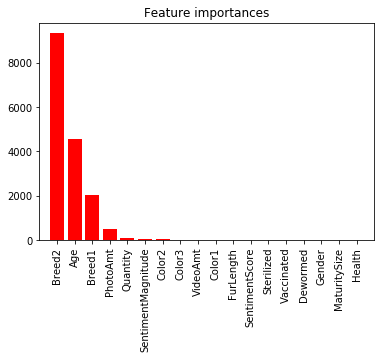

In [36]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

X = df_preprocess[['Age', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Gender', 'MaturitySize', 'FurLength', 
                  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore']]

y = df_preprocess['AdoptionSpeed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores = featureScores.nlargest(X_train.shape[1],'Score')
print(featureScores)  #print 10 best features

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), featureScores['Score'],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), featureScores['Specs'], rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

<H2>2.  Feature Importance</H2>

0:	learn: 0.2025276	test: 0.2332804	best: 0.2332804 (0)	total: 361ms	remaining: 6m
1:	learn: 0.2216651	test: 0.2443592	best: 0.2443592 (1)	total: 705ms	remaining: 5m 51s
2:	learn: 0.2316874	test: 0.2616870	best: 0.2616870 (2)	total: 1.06s	remaining: 5m 52s
3:	learn: 0.2394113	test: 0.2659783	best: 0.2659783 (3)	total: 1.35s	remaining: 5m 35s
4:	learn: 0.2449928	test: 0.2677899	best: 0.2677899 (4)	total: 1.65s	remaining: 5m 28s
5:	learn: 0.2440340	test: 0.2635798	best: 0.2677899 (4)	total: 1.82s	remaining: 5m 2s
6:	learn: 0.2491603	test: 0.2653381	best: 0.2677899 (4)	total: 2.12s	remaining: 5m
7:	learn: 0.2514430	test: 0.2741064	best: 0.2741064 (7)	total: 2.48s	remaining: 5m 7s
8:	learn: 0.2531420	test: 0.2752955	best: 0.2752955 (8)	total: 2.74s	remaining: 5m 1s
9:	learn: 0.2532508	test: 0.2751643	best: 0.2752955 (8)	total: 3.07s	remaining: 5m 3s
10:	learn: 0.2580001	test: 0.2820955	best: 0.2820955 (10)	total: 3.45s	remaining: 5m 9s
11:	learn: 0.2606750	test: 0.2839989	best: 0.2839989 (

94:	learn: 0.2875096	test: 0.2817331	best: 0.2846678 (12)	total: 28.5s	remaining: 4m 31s
95:	learn: 0.2867538	test: 0.2840520	best: 0.2846678 (12)	total: 28.7s	remaining: 4m 29s
96:	learn: 0.2868817	test: 0.2832932	best: 0.2846678 (12)	total: 29s	remaining: 4m 30s
97:	learn: 0.2865858	test: 0.2836616	best: 0.2846678 (12)	total: 29.3s	remaining: 4m 29s
98:	learn: 0.2854988	test: 0.2821431	best: 0.2846678 (12)	total: 29.5s	remaining: 4m 28s
99:	learn: 0.2856549	test: 0.2812904	best: 0.2846678 (12)	total: 29.8s	remaining: 4m 28s
100:	learn: 0.2863355	test: 0.2834120	best: 0.2846678 (12)	total: 30.1s	remaining: 4m 27s
101:	learn: 0.2871819	test: 0.2833063	best: 0.2846678 (12)	total: 30.4s	remaining: 4m 28s
102:	learn: 0.2864704	test: 0.2856173	best: 0.2856173 (102)	total: 30.8s	remaining: 4m 27s
103:	learn: 0.2864909	test: 0.2881039	best: 0.2881039 (103)	total: 31.2s	remaining: 4m 28s
104:	learn: 0.2854237	test: 0.2840758	best: 0.2881039 (103)	total: 31.5s	remaining: 4m 28s
105:	learn: 0.2

186:	learn: 0.2968705	test: 0.2846068	best: 0.2881039 (103)	total: 54.1s	remaining: 3m 55s
187:	learn: 0.2991850	test: 0.2861691	best: 0.2881039 (103)	total: 54.4s	remaining: 3m 55s
188:	learn: 0.2983284	test: 0.2852512	best: 0.2881039 (103)	total: 54.8s	remaining: 3m 54s
189:	learn: 0.3001107	test: 0.2874909	best: 0.2881039 (103)	total: 55.1s	remaining: 3m 54s
190:	learn: 0.3000341	test: 0.2862909	best: 0.2881039 (103)	total: 55.3s	remaining: 3m 54s
191:	learn: 0.3002722	test: 0.2867123	best: 0.2881039 (103)	total: 55.7s	remaining: 3m 54s
192:	learn: 0.3005906	test: 0.2849121	best: 0.2881039 (103)	total: 55.9s	remaining: 3m 53s
193:	learn: 0.3017228	test: 0.2870347	best: 0.2881039 (103)	total: 56.2s	remaining: 3m 53s
194:	learn: 0.3020058	test: 0.2864769	best: 0.2881039 (103)	total: 56.6s	remaining: 3m 53s
195:	learn: 0.3016112	test: 0.2878329	best: 0.2881039 (103)	total: 56.9s	remaining: 3m 53s
196:	learn: 0.3022376	test: 0.2869172	best: 0.2881039 (103)	total: 57s	remaining: 3m 52s
1

276:	learn: 0.3123460	test: 0.2919583	best: 0.2942474 (265)	total: 1m 20s	remaining: 3m 29s
277:	learn: 0.3130449	test: 0.2927459	best: 0.2942474 (265)	total: 1m 20s	remaining: 3m 29s
278:	learn: 0.3133069	test: 0.2921831	best: 0.2942474 (265)	total: 1m 21s	remaining: 3m 29s
279:	learn: 0.3135281	test: 0.2923941	best: 0.2942474 (265)	total: 1m 21s	remaining: 3m 29s
280:	learn: 0.3150765	test: 0.2917473	best: 0.2942474 (265)	total: 1m 21s	remaining: 3m 29s
281:	learn: 0.3171092	test: 0.2907863	best: 0.2942474 (265)	total: 1m 22s	remaining: 3m 29s
282:	learn: 0.3162510	test: 0.2904446	best: 0.2942474 (265)	total: 1m 22s	remaining: 3m 28s
283:	learn: 0.3166358	test: 0.2903547	best: 0.2942474 (265)	total: 1m 22s	remaining: 3m 28s
284:	learn: 0.3169493	test: 0.2910950	best: 0.2942474 (265)	total: 1m 22s	remaining: 3m 27s
285:	learn: 0.3164261	test: 0.2911915	best: 0.2942474 (265)	total: 1m 23s	remaining: 3m 27s
286:	learn: 0.3171670	test: 0.2914779	best: 0.2942474 (265)	total: 1m 23s	remain

366:	learn: 0.3321391	test: 0.2968822	best: 0.2982163 (365)	total: 1m 50s	remaining: 3m 10s
367:	learn: 0.3323929	test: 0.2960684	best: 0.2982163 (365)	total: 1m 50s	remaining: 3m 9s
368:	learn: 0.3340292	test: 0.2978021	best: 0.2982163 (365)	total: 1m 50s	remaining: 3m 9s
369:	learn: 0.3334743	test: 0.2999319	best: 0.2999319 (369)	total: 1m 51s	remaining: 3m 9s
370:	learn: 0.3335114	test: 0.3001272	best: 0.3001272 (370)	total: 1m 51s	remaining: 3m 9s
371:	learn: 0.3335432	test: 0.2999923	best: 0.3001272 (370)	total: 1m 51s	remaining: 3m 8s
372:	learn: 0.3338835	test: 0.3009871	best: 0.3009871 (372)	total: 1m 52s	remaining: 3m 8s
373:	learn: 0.3335284	test: 0.3005388	best: 0.3009871 (372)	total: 1m 52s	remaining: 3m 8s
374:	learn: 0.3340224	test: 0.3008220	best: 0.3009871 (372)	total: 1m 52s	remaining: 3m 8s
375:	learn: 0.3334004	test: 0.2982620	best: 0.3009871 (372)	total: 1m 53s	remaining: 3m 8s
376:	learn: 0.3330298	test: 0.2991037	best: 0.3009871 (372)	total: 1m 53s	remaining: 3m 7

457:	learn: 0.3483061	test: 0.3018177	best: 0.3035547 (452)	total: 2m 21s	remaining: 2m 47s
458:	learn: 0.3484118	test: 0.3008654	best: 0.3035547 (452)	total: 2m 22s	remaining: 2m 47s
459:	learn: 0.3497441	test: 0.3025002	best: 0.3035547 (452)	total: 2m 22s	remaining: 2m 47s
460:	learn: 0.3498784	test: 0.3024883	best: 0.3035547 (452)	total: 2m 22s	remaining: 2m 47s
461:	learn: 0.3498080	test: 0.3026605	best: 0.3035547 (452)	total: 2m 23s	remaining: 2m 46s
462:	learn: 0.3486338	test: 0.3020371	best: 0.3035547 (452)	total: 2m 23s	remaining: 2m 46s
463:	learn: 0.3489245	test: 0.3009342	best: 0.3035547 (452)	total: 2m 23s	remaining: 2m 46s
464:	learn: 0.3496767	test: 0.2996128	best: 0.3035547 (452)	total: 2m 24s	remaining: 2m 45s
465:	learn: 0.3503043	test: 0.3006928	best: 0.3035547 (452)	total: 2m 24s	remaining: 2m 45s
466:	learn: 0.3496607	test: 0.2992208	best: 0.3035547 (452)	total: 2m 24s	remaining: 2m 45s
467:	learn: 0.3487919	test: 0.2999435	best: 0.3035547 (452)	total: 2m 25s	remain

547:	learn: 0.3629666	test: 0.3058255	best: 0.3085027 (544)	total: 2m 53s	remaining: 2m 22s
548:	learn: 0.3620528	test: 0.3055910	best: 0.3085027 (544)	total: 2m 53s	remaining: 2m 22s
549:	learn: 0.3630131	test: 0.3056916	best: 0.3085027 (544)	total: 2m 53s	remaining: 2m 22s
550:	learn: 0.3625353	test: 0.3043185	best: 0.3085027 (544)	total: 2m 54s	remaining: 2m 21s
551:	learn: 0.3621299	test: 0.3062504	best: 0.3085027 (544)	total: 2m 54s	remaining: 2m 21s
552:	learn: 0.3615808	test: 0.3062697	best: 0.3085027 (544)	total: 2m 54s	remaining: 2m 21s
553:	learn: 0.3613277	test: 0.3066358	best: 0.3085027 (544)	total: 2m 55s	remaining: 2m 21s
554:	learn: 0.3613519	test: 0.3067069	best: 0.3085027 (544)	total: 2m 55s	remaining: 2m 20s
555:	learn: 0.3613970	test: 0.3066237	best: 0.3085027 (544)	total: 2m 56s	remaining: 2m 20s
556:	learn: 0.3617102	test: 0.3082247	best: 0.3085027 (544)	total: 2m 56s	remaining: 2m 20s
557:	learn: 0.3598554	test: 0.3063283	best: 0.3085027 (544)	total: 2m 56s	remain

637:	learn: 0.3714977	test: 0.3106018	best: 0.3136963 (632)	total: 3m 24s	remaining: 1m 56s
638:	learn: 0.3709853	test: 0.3106235	best: 0.3136963 (632)	total: 3m 25s	remaining: 1m 55s
639:	learn: 0.3723807	test: 0.3103839	best: 0.3136963 (632)	total: 3m 25s	remaining: 1m 55s
640:	learn: 0.3714331	test: 0.3104505	best: 0.3136963 (632)	total: 3m 25s	remaining: 1m 55s
641:	learn: 0.3709959	test: 0.3095330	best: 0.3136963 (632)	total: 3m 26s	remaining: 1m 54s
642:	learn: 0.3708869	test: 0.3089413	best: 0.3136963 (632)	total: 3m 26s	remaining: 1m 54s
643:	learn: 0.3716665	test: 0.3091541	best: 0.3136963 (632)	total: 3m 26s	remaining: 1m 54s
644:	learn: 0.3715374	test: 0.3091541	best: 0.3136963 (632)	total: 3m 27s	remaining: 1m 54s
645:	learn: 0.3714563	test: 0.3094764	best: 0.3136963 (632)	total: 3m 27s	remaining: 1m 53s
646:	learn: 0.3713994	test: 0.3091001	best: 0.3136963 (632)	total: 3m 27s	remaining: 1m 53s
647:	learn: 0.3710191	test: 0.3085734	best: 0.3136963 (632)	total: 3m 28s	remain

727:	learn: 0.3829510	test: 0.3104931	best: 0.3157654 (677)	total: 3m 55s	remaining: 1m 28s
728:	learn: 0.3826083	test: 0.3106987	best: 0.3157654 (677)	total: 3m 56s	remaining: 1m 27s
729:	learn: 0.3820677	test: 0.3100315	best: 0.3157654 (677)	total: 3m 56s	remaining: 1m 27s
730:	learn: 0.3823835	test: 0.3103723	best: 0.3157654 (677)	total: 3m 56s	remaining: 1m 27s
731:	learn: 0.3820294	test: 0.3088292	best: 0.3157654 (677)	total: 3m 57s	remaining: 1m 26s
732:	learn: 0.3822792	test: 0.3122109	best: 0.3157654 (677)	total: 3m 57s	remaining: 1m 26s
733:	learn: 0.3828352	test: 0.3122462	best: 0.3157654 (677)	total: 3m 57s	remaining: 1m 26s
734:	learn: 0.3826919	test: 0.3108996	best: 0.3157654 (677)	total: 3m 58s	remaining: 1m 25s
735:	learn: 0.3831624	test: 0.3119295	best: 0.3157654 (677)	total: 3m 58s	remaining: 1m 25s
736:	learn: 0.3827848	test: 0.3116801	best: 0.3157654 (677)	total: 3m 59s	remaining: 1m 25s
737:	learn: 0.3833081	test: 0.3116703	best: 0.3157654 (677)	total: 3m 59s	remain

817:	learn: 0.3900671	test: 0.3109797	best: 0.3164023 (756)	total: 4m 27s	remaining: 59.5s
818:	learn: 0.3902397	test: 0.3109439	best: 0.3164023 (756)	total: 4m 27s	remaining: 59.2s
819:	learn: 0.3899661	test: 0.3113754	best: 0.3164023 (756)	total: 4m 28s	remaining: 58.9s
820:	learn: 0.3898937	test: 0.3125169	best: 0.3164023 (756)	total: 4m 28s	remaining: 58.5s
821:	learn: 0.3897273	test: 0.3110425	best: 0.3164023 (756)	total: 4m 28s	remaining: 58.2s
822:	learn: 0.3907591	test: 0.3107189	best: 0.3164023 (756)	total: 4m 29s	remaining: 57.9s
823:	learn: 0.3902574	test: 0.3120041	best: 0.3164023 (756)	total: 4m 29s	remaining: 57.6s
824:	learn: 0.3904150	test: 0.3120041	best: 0.3164023 (756)	total: 4m 29s	remaining: 57.3s
825:	learn: 0.3912669	test: 0.3115238	best: 0.3164023 (756)	total: 4m 30s	remaining: 56.9s
826:	learn: 0.3908648	test: 0.3118076	best: 0.3164023 (756)	total: 4m 30s	remaining: 56.6s
827:	learn: 0.3911042	test: 0.3117806	best: 0.3164023 (756)	total: 4m 30s	remaining: 56.3s

908:	learn: 0.4018020	test: 0.3191291	best: 0.3203391 (903)	total: 4m 59s	remaining: 30s
909:	learn: 0.4021001	test: 0.3191291	best: 0.3203391 (903)	total: 4m 59s	remaining: 29.7s
910:	learn: 0.4021598	test: 0.3177585	best: 0.3203391 (903)	total: 5m	remaining: 29.3s
911:	learn: 0.4019597	test: 0.3175017	best: 0.3203391 (903)	total: 5m	remaining: 29s
912:	learn: 0.4016805	test: 0.3168185	best: 0.3203391 (903)	total: 5m 1s	remaining: 28.7s
913:	learn: 0.4017149	test: 0.3169221	best: 0.3203391 (903)	total: 5m 1s	remaining: 28.4s
914:	learn: 0.4014006	test: 0.3168807	best: 0.3203391 (903)	total: 5m 1s	remaining: 28s
915:	learn: 0.4013912	test: 0.3165102	best: 0.3203391 (903)	total: 5m 2s	remaining: 27.7s
916:	learn: 0.4028194	test: 0.3160389	best: 0.3203391 (903)	total: 5m 2s	remaining: 27.4s
917:	learn: 0.4020404	test: 0.3156203	best: 0.3203391 (903)	total: 5m 2s	remaining: 27s
918:	learn: 0.4025207	test: 0.3164149	best: 0.3203391 (903)	total: 5m 3s	remaining: 26.7s
919:	learn: 0.4023110	

999:	learn: 0.4086169	test: 0.3195319	best: 0.3220586 (989)	total: 5m 31s	remaining: 0us

bestTest = 0.3220586199
bestIteration = 989

Shrink model to first 990 iterations.
Quadaratic weighted Kappa: 0.32205861989702966
Feature ranking:
1. Breed1 (16.495192)
2. Age (11.750608)
3. PhotoAmt (8.856637)
4. Sterilized (7.672227)
5. Breed2 (7.511756)
6. Gender (6.100118)
7. Color1 (5.934610)
8. SentimentMagnitude (5.511779)
9. Color2 (5.441506)
10. Dewormed (4.829694)
11. Quantity (4.803250)
12. Color3 (3.696074)
13. Vaccinated (3.633877)
14. MaturitySize (3.102789)
15. SentimentScore (2.300800)
16. FurLength (1.566067)
17. VideoAmt (0.690002)
18. Health (0.103015)


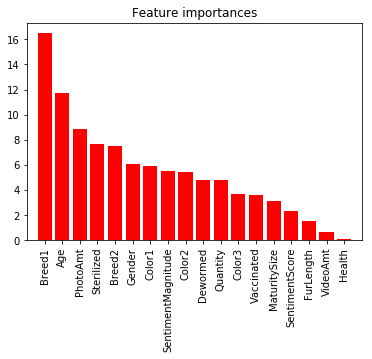

In [37]:
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import cohen_kappa_score

    

X = df_preprocess[['Age', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Gender', 'MaturitySize', 'FurLength', 
                  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore']]

y = df_preprocess['AdoptionSpeed']

train_data, eval_data, train_labels, eval_labels = train_test_split(X, y, test_size=0.33, random_state=42)

cat_features = [1, 2, 3, 4, 5, 6, 9, 10, 11]
class_weight = [1, 0.13, 0.10, 0.13, 0.10]

train_dataset = Pool(data=train_data,
                     label=train_labels,
                     cat_features=cat_features)

eval_dataset = Pool(data=eval_data,
                    label=eval_labels,
                    cat_features=cat_features)

model = CatBoostClassifier(use_best_model=True, loss_function='MultiClass', eval_metric='WKappa',
                           class_weights=class_weight, random_seed=100)

model.fit(train_dataset, eval_set=eval_dataset)

print(model)

preds_class = model.predict(eval_dataset)

print('Quadaratic weighted Kappa:', cohen_kappa_score(eval_labels, preds_class, weights='quadratic'))

#print("Feature ranking:")
#fea_imp_prediction = model.get_feature_importance(type='PredictionValuesChange', prettified=True, thread_count=-1, verbose=False)
#fea_imp_prediction

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

<H2>3. Correlation Matrix with Heatmap</H2>

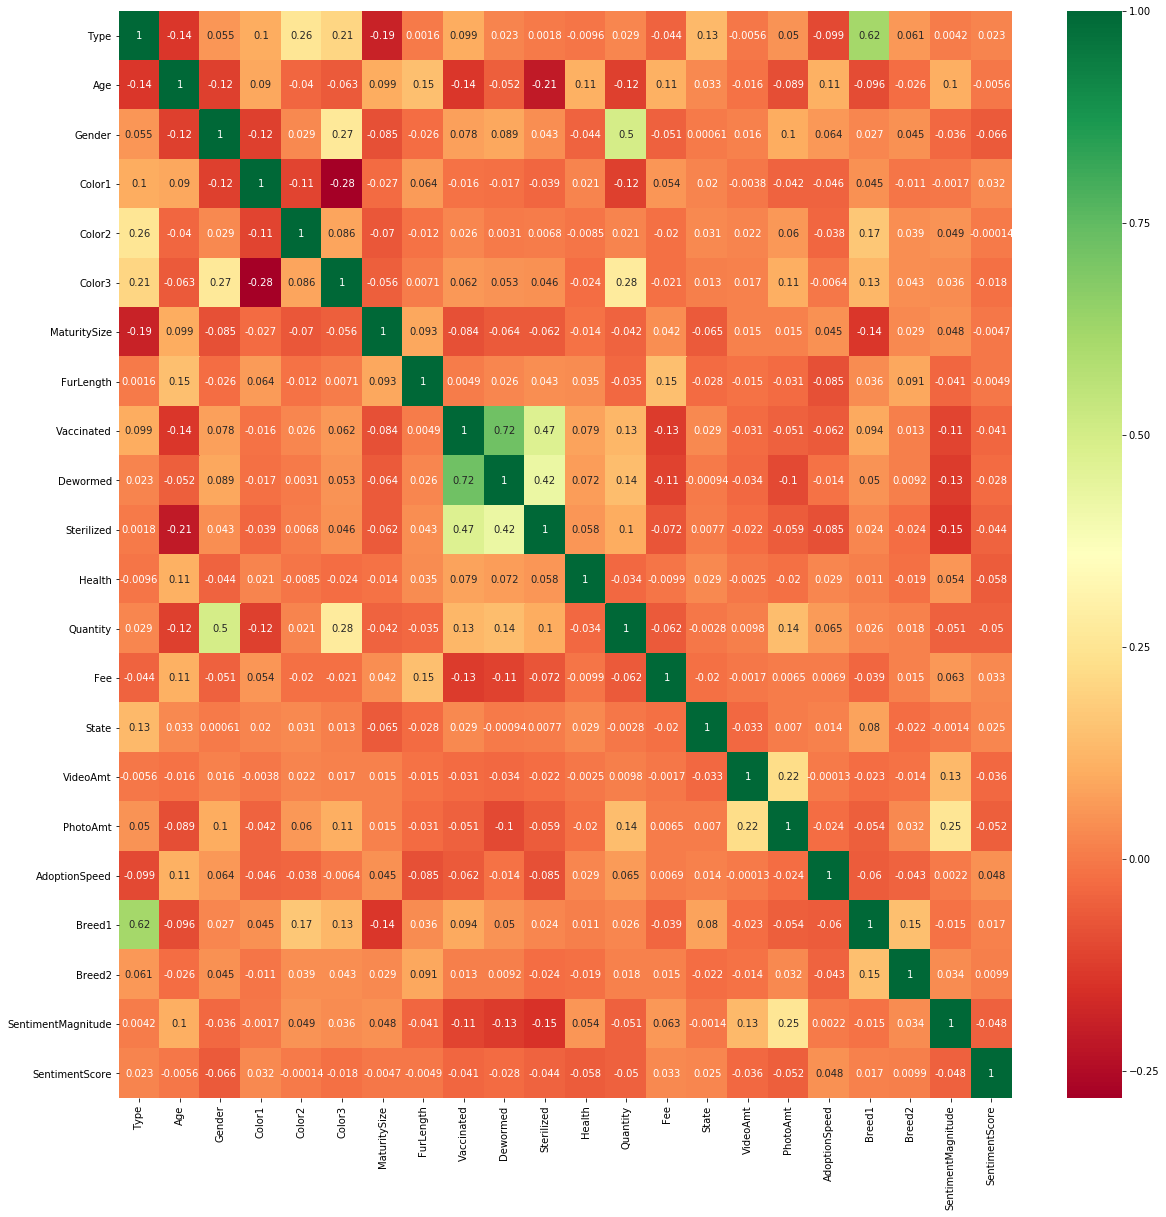

In [38]:
df_heatmap = df_preprocess

#get correlations of each features in dataset
corrmat = df_heatmap.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_heatmap[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<H1>Modeling</H1>

<H2>CatBoost Baseline Model</H2>

For CatBoost, categorical features are taken care of by the cat_features parameter in the CatBoost model.  All we have to do is just to pass in the list of categorical features as an array of column positions to the model.

In [39]:
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import cohen_kappa_score

    

X = df_preprocess[['Age', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Gender', 'MaturitySize', 'FurLength', 
                  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore']]

y = df_preprocess['AdoptionSpeed']

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.33, random_state=42)

cat_features = [1, 2, 3, 4, 5, 6, 9, 10, 11]
class_weight = [1, 0.13, 0.10, 0.13, 0.10]

train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features)

eval_dataset = Pool(data=eval_data,
                    cat_features=cat_features)

model = CatBoostClassifier(loss_function='MultiClass', eval_metric='WKappa', od_type='Iter',
                           class_weights=class_weight, random_seed=10)

model.fit(train_dataset)

print(model)

preds_class = model.predict(X_eval)

print('Quadaratic weighted Kappa:', cohen_kappa_score(y_eval, preds_class, weights='quadratic'))

print(model.get_params())
print('feature names: {}'.format(model.feature_names_))
print('best score: {}'.format(model.best_score_))
print('learning rate: {}'.format(model.learning_rate_))
print('tree count: {}'.format(model.tree_count_))
print('best iteration: {}'.format(model.best_iteration_))
print('classes: {}'.format(model.classes_))

0:	learn: 0.1641512	total: 295ms	remaining: 4m 54s
1:	learn: 0.1975582	total: 544ms	remaining: 4m 31s
2:	learn: 0.2235770	total: 789ms	remaining: 4m 22s
3:	learn: 0.2370512	total: 1.1s	remaining: 4m 35s
4:	learn: 0.2390803	total: 1.43s	remaining: 4m 45s
5:	learn: 0.2408968	total: 1.78s	remaining: 4m 54s
6:	learn: 0.2453481	total: 2.09s	remaining: 4m 56s
7:	learn: 0.2589103	total: 2.47s	remaining: 5m 5s
8:	learn: 0.2646091	total: 2.58s	remaining: 4m 43s
9:	learn: 0.2704535	total: 2.9s	remaining: 4m 47s
10:	learn: 0.2683086	total: 3.22s	remaining: 4m 49s
11:	learn: 0.2704368	total: 3.32s	remaining: 4m 33s
12:	learn: 0.2736043	total: 3.65s	remaining: 4m 37s
13:	learn: 0.2697834	total: 4.02s	remaining: 4m 43s
14:	learn: 0.2727831	total: 4.36s	remaining: 4m 46s
15:	learn: 0.2703661	total: 4.61s	remaining: 4m 43s
16:	learn: 0.2739625	total: 4.96s	remaining: 4m 46s
17:	learn: 0.2744820	total: 5.13s	remaining: 4m 40s
18:	learn: 0.2819103	total: 5.43s	remaining: 4m 40s
19:	learn: 0.2810438	tota

158:	learn: 0.3076799	total: 45.6s	remaining: 4m 1s
159:	learn: 0.3084223	total: 45.8s	remaining: 4m
160:	learn: 0.3083712	total: 46.2s	remaining: 4m
161:	learn: 0.3064966	total: 46.5s	remaining: 4m
162:	learn: 0.3075958	total: 46.6s	remaining: 3m 59s
163:	learn: 0.3066542	total: 46.9s	remaining: 3m 59s
164:	learn: 0.3060803	total: 47.1s	remaining: 3m 58s
165:	learn: 0.3067589	total: 47.2s	remaining: 3m 57s
166:	learn: 0.3085584	total: 47.6s	remaining: 3m 57s
167:	learn: 0.3098063	total: 47.9s	remaining: 3m 57s
168:	learn: 0.3089189	total: 48.2s	remaining: 3m 56s
169:	learn: 0.3103392	total: 48.5s	remaining: 3m 56s
170:	learn: 0.3108103	total: 48.8s	remaining: 3m 56s
171:	learn: 0.3116471	total: 49.1s	remaining: 3m 56s
172:	learn: 0.3100602	total: 49.4s	remaining: 3m 56s
173:	learn: 0.3103890	total: 49.5s	remaining: 3m 54s
174:	learn: 0.3092706	total: 49.8s	remaining: 3m 54s
175:	learn: 0.3095235	total: 50s	remaining: 3m 54s
176:	learn: 0.3098036	total: 50.3s	remaining: 3m 54s
177:	lea

313:	learn: 0.3314397	total: 1m 28s	remaining: 3m 12s
314:	learn: 0.3332534	total: 1m 28s	remaining: 3m 12s
315:	learn: 0.3326274	total: 1m 28s	remaining: 3m 12s
316:	learn: 0.3325648	total: 1m 29s	remaining: 3m 11s
317:	learn: 0.3328351	total: 1m 29s	remaining: 3m 11s
318:	learn: 0.3317045	total: 1m 29s	remaining: 3m 11s
319:	learn: 0.3323912	total: 1m 30s	remaining: 3m 11s
320:	learn: 0.3325878	total: 1m 30s	remaining: 3m 11s
321:	learn: 0.3323274	total: 1m 30s	remaining: 3m 11s
322:	learn: 0.3332505	total: 1m 31s	remaining: 3m 10s
323:	learn: 0.3334061	total: 1m 31s	remaining: 3m 10s
324:	learn: 0.3335512	total: 1m 31s	remaining: 3m 10s
325:	learn: 0.3333019	total: 1m 32s	remaining: 3m 10s
326:	learn: 0.3339209	total: 1m 32s	remaining: 3m 10s
327:	learn: 0.3341323	total: 1m 32s	remaining: 3m 9s
328:	learn: 0.3334371	total: 1m 33s	remaining: 3m 9s
329:	learn: 0.3327243	total: 1m 33s	remaining: 3m 9s
330:	learn: 0.3324385	total: 1m 33s	remaining: 3m 9s
331:	learn: 0.3321844	total: 1m 

467:	learn: 0.3548706	total: 2m 19s	remaining: 2m 39s
468:	learn: 0.3540125	total: 2m 20s	remaining: 2m 38s
469:	learn: 0.3529609	total: 2m 20s	remaining: 2m 38s
470:	learn: 0.3532278	total: 2m 20s	remaining: 2m 38s
471:	learn: 0.3537240	total: 2m 21s	remaining: 2m 38s
472:	learn: 0.3549151	total: 2m 21s	remaining: 2m 37s
473:	learn: 0.3543859	total: 2m 21s	remaining: 2m 37s
474:	learn: 0.3565088	total: 2m 22s	remaining: 2m 37s
475:	learn: 0.3563210	total: 2m 22s	remaining: 2m 37s
476:	learn: 0.3562687	total: 2m 23s	remaining: 2m 36s
477:	learn: 0.3566205	total: 2m 23s	remaining: 2m 36s
478:	learn: 0.3567568	total: 2m 23s	remaining: 2m 36s
479:	learn: 0.3567613	total: 2m 23s	remaining: 2m 35s
480:	learn: 0.3571577	total: 2m 24s	remaining: 2m 35s
481:	learn: 0.3574896	total: 2m 24s	remaining: 2m 35s
482:	learn: 0.3576357	total: 2m 24s	remaining: 2m 35s
483:	learn: 0.3568486	total: 2m 25s	remaining: 2m 34s
484:	learn: 0.3588786	total: 2m 25s	remaining: 2m 34s
485:	learn: 0.3594052	total:

621:	learn: 0.3784811	total: 3m 12s	remaining: 1m 57s
622:	learn: 0.3788181	total: 3m 12s	remaining: 1m 56s
623:	learn: 0.3771929	total: 3m 13s	remaining: 1m 56s
624:	learn: 0.3784306	total: 3m 13s	remaining: 1m 56s
625:	learn: 0.3777309	total: 3m 13s	remaining: 1m 55s
626:	learn: 0.3779586	total: 3m 14s	remaining: 1m 55s
627:	learn: 0.3791741	total: 3m 14s	remaining: 1m 55s
628:	learn: 0.3790546	total: 3m 14s	remaining: 1m 54s
629:	learn: 0.3785282	total: 3m 15s	remaining: 1m 54s
630:	learn: 0.3785767	total: 3m 15s	remaining: 1m 54s
631:	learn: 0.3785941	total: 3m 15s	remaining: 1m 54s
632:	learn: 0.3787851	total: 3m 16s	remaining: 1m 53s
633:	learn: 0.3784792	total: 3m 16s	remaining: 1m 53s
634:	learn: 0.3788480	total: 3m 16s	remaining: 1m 53s
635:	learn: 0.3783616	total: 3m 17s	remaining: 1m 52s
636:	learn: 0.3776872	total: 3m 17s	remaining: 1m 52s
637:	learn: 0.3780292	total: 3m 17s	remaining: 1m 52s
638:	learn: 0.3795482	total: 3m 18s	remaining: 1m 52s
639:	learn: 0.3794952	total:

774:	learn: 0.3995860	total: 4m 4s	remaining: 1m 11s
775:	learn: 0.3993524	total: 4m 5s	remaining: 1m 10s
776:	learn: 0.3997581	total: 4m 5s	remaining: 1m 10s
777:	learn: 0.3998489	total: 4m 5s	remaining: 1m 10s
778:	learn: 0.3993424	total: 4m 6s	remaining: 1m 9s
779:	learn: 0.4004634	total: 4m 6s	remaining: 1m 9s
780:	learn: 0.4008346	total: 4m 6s	remaining: 1m 9s
781:	learn: 0.4007332	total: 4m 7s	remaining: 1m 8s
782:	learn: 0.4016085	total: 4m 7s	remaining: 1m 8s
783:	learn: 0.4015605	total: 4m 7s	remaining: 1m 8s
784:	learn: 0.4018365	total: 4m 8s	remaining: 1m 7s
785:	learn: 0.4013225	total: 4m 8s	remaining: 1m 7s
786:	learn: 0.4010854	total: 4m 8s	remaining: 1m 7s
787:	learn: 0.4011686	total: 4m 9s	remaining: 1m 7s
788:	learn: 0.4009761	total: 4m 9s	remaining: 1m 6s
789:	learn: 0.4020064	total: 4m 9s	remaining: 1m 6s
790:	learn: 0.4023959	total: 4m 10s	remaining: 1m 6s
791:	learn: 0.4017261	total: 4m 10s	remaining: 1m 5s
792:	learn: 0.4016586	total: 4m 10s	remaining: 1m 5s
793:	

930:	learn: 0.4135277	total: 4m 58s	remaining: 22.1s
931:	learn: 0.4144595	total: 4m 58s	remaining: 21.8s
932:	learn: 0.4148987	total: 4m 58s	remaining: 21.5s
933:	learn: 0.4148987	total: 4m 59s	remaining: 21.1s
934:	learn: 0.4153173	total: 4m 59s	remaining: 20.8s
935:	learn: 0.4151704	total: 4m 59s	remaining: 20.5s
936:	learn: 0.4149585	total: 5m	remaining: 20.2s
937:	learn: 0.4146974	total: 5m	remaining: 19.9s
938:	learn: 0.4146532	total: 5m	remaining: 19.5s
939:	learn: 0.4151698	total: 5m 1s	remaining: 19.2s
940:	learn: 0.4150959	total: 5m 1s	remaining: 18.9s
941:	learn: 0.4153198	total: 5m 1s	remaining: 18.6s
942:	learn: 0.4154127	total: 5m 2s	remaining: 18.3s
943:	learn: 0.4154191	total: 5m 2s	remaining: 17.9s
944:	learn: 0.4159374	total: 5m 2s	remaining: 17.6s
945:	learn: 0.4160802	total: 5m 3s	remaining: 17.3s
946:	learn: 0.4161176	total: 5m 3s	remaining: 17s
947:	learn: 0.4168283	total: 5m 3s	remaining: 16.7s
948:	learn: 0.4166205	total: 5m 4s	remaining: 16.3s
949:	learn: 0.416

Using the baseline model, CatBoost has a Cohen Kappa score of 0.306185.  We can further improve the model by doing some hyperparameter tuning as shown in the following section.

<H1>Hyperparameter Tuning</H1>

In [ ]:
# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

In [ ]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
from catboost import Pool, cv

# Global variable
global  ITERATION

ITERATION = 0
N_FOLDS = 10
MAX_EVALS = 100

# Define the search space
space = {
    'loss_function': hp.choice('loss_function', ['MultiClass']),
    'eval_metric': hp.choice('eval_metric', ['WKappa']),
    'od_type': hp.choice('od_type', ['Iter']),
    'iterations': 200,
    'class_weights': class_weight,
    'classes_count': 5,
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'depth': hp.quniform('depth', 6, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3.0, 10.0), 
    'random_strength': hp.uniform('random_strength', 1.0, 5.0)
    #'grow_policy': hp.choice('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
}

# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['depth']:
        params[parameter_name] = int(params[parameter_name])
    
    for parameter_name in ['learning_rate', 'l2_leaf_reg', 'random_strength']:
        params[parameter_name] = float(params[parameter_name])
        
    start = timer()
    
    # Perform n_fold cross validation with hyperparameters
    cat_features = [1, 2, 3, 4, 5, 6, 9, 10, 11]
    class_weight = [1, 0.13, 0.10, 0.13, 0.10]

    train_dataset = Pool(data=X_train,
                         label=y_train,
                         cat_features=cat_features)
    
    # Perform n_folds cross validation
    cv_results = cv(pool = train_dataset, params = params, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.min(cv_results['test-WKappa-mean']
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    #n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            #'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}



In [ ]:
# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

In [ ]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

In [ ]:
import ast

results = pd.read_csv('gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

From the hyperparameter tuning, the best params obtained are
<br>
<br>
                    {'classes_count': 5, 
                     'loss_function': 'MultiClass', 
                     'class_weights': (1, 0.13, 0.1, 0.13, 0.1), 
                     'od_type': 'Iter', 
                     'eval_metric': 'WKappa', 
                     'l2_leaf_reg': 9.63868941568644, 
                     'random_strength': 2.3643707730085426, 
                     'learning_rate': 0.19991137844395668, 
                     'iterations': 200, 
                     'depth': 10}

<H1>Train using the best params</H1>

In [40]:
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import cohen_kappa_score

X = df_preprocess[['Age', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Gender', 'MaturitySize', 'FurLength', 
                  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore']]

y = df_preprocess['AdoptionSpeed']

cat_features = [1, 2, 3, 4, 5, 6, 9, 10, 11]
class_weight = [1, 0.13, 0.10, 0.13, 0.10]

train_dataset = Pool(data=X,
                     label=y,
                     cat_features=cat_features)

best_bayes_params = {'classes_count': 5, 
                     'loss_function': 'MultiClass', 
                     'class_weights': (1, 0.13, 0.1, 0.13, 0.1), 
                     'od_type': 'Iter', 
                     'eval_metric': 'WKappa', 
                     'l2_leaf_reg': 9.63868941568644, 
                     'random_strength': 2.3643707730085426, 
                     'learning_rate': 0.19991137844395668, 
                     'iterations': 200, 
                     'depth': 10}

model = CatBoostClassifier(random_seed=10, **best_bayes_params)

model.fit(train_dataset)

print(model)


0:	learn: 0.1809085	total: 768ms	remaining: 2m 32s
1:	learn: 0.1889045	total: 2.2s	remaining: 3m 37s
2:	learn: 0.2187453	total: 2.46s	remaining: 2m 41s
3:	learn: 0.2285726	total: 2.9s	remaining: 2m 22s
4:	learn: 0.2349645	total: 6.45s	remaining: 4m 11s
5:	learn: 0.2453391	total: 7.57s	remaining: 4m 4s
6:	learn: 0.2503539	total: 8.82s	remaining: 4m 3s
7:	learn: 0.2478142	total: 9.1s	remaining: 3m 38s
8:	learn: 0.2595987	total: 10.9s	remaining: 3m 52s
9:	learn: 0.2615561	total: 11.2s	remaining: 3m 32s
10:	learn: 0.2577418	total: 11.6s	remaining: 3m 19s
11:	learn: 0.2561589	total: 11.7s	remaining: 3m 3s
12:	learn: 0.2603814	total: 12.3s	remaining: 2m 57s
13:	learn: 0.2610877	total: 12.4s	remaining: 2m 45s
14:	learn: 0.2595596	total: 13s	remaining: 2m 39s
15:	learn: 0.2608753	total: 13.1s	remaining: 2m 31s
16:	learn: 0.2625158	total: 13.8s	remaining: 2m 28s
17:	learn: 0.2678766	total: 14.6s	remaining: 2m 27s
18:	learn: 0.2688964	total: 14.8s	remaining: 2m 20s
19:	learn: 0.2662648	total: 15

157:	learn: 0.4091771	total: 6m 31s	remaining: 1m 44s
158:	learn: 0.4091273	total: 6m 35s	remaining: 1m 41s
159:	learn: 0.4148474	total: 6m 37s	remaining: 1m 39s
160:	learn: 0.4147137	total: 6m 40s	remaining: 1m 37s
161:	learn: 0.4150175	total: 6m 43s	remaining: 1m 34s
162:	learn: 0.4154817	total: 6m 47s	remaining: 1m 32s
163:	learn: 0.4173015	total: 6m 50s	remaining: 1m 30s
164:	learn: 0.4155607	total: 6m 54s	remaining: 1m 27s
165:	learn: 0.4196892	total: 6m 57s	remaining: 1m 25s
166:	learn: 0.4191624	total: 7m 1s	remaining: 1m 23s
167:	learn: 0.4185399	total: 7m 4s	remaining: 1m 20s
168:	learn: 0.4188573	total: 7m 7s	remaining: 1m 18s
169:	learn: 0.4199332	total: 7m 9s	remaining: 1m 15s
170:	learn: 0.4202688	total: 7m 12s	remaining: 1m 13s
171:	learn: 0.4209894	total: 7m 16s	remaining: 1m 11s
172:	learn: 0.4204890	total: 7m 20s	remaining: 1m 8s
173:	learn: 0.4212203	total: 7m 23s	remaining: 1m 6s
174:	learn: 0.4218294	total: 7m 27s	remaining: 1m 3s
175:	learn: 0.4224137	total: 7m 29s

In [41]:
# getting test dataset for prediction
df_test = pd.read_csv("../input/test/test.csv")
df_test.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt
0,2,Dopey & Grey,8,266,266,1,2,6,7,1,1,1,1,2,1,2,0,41326,2ece3b2573dcdcebd774e635dca15fd9,0,"Dopey Age: 8mths old Male One half of a pair, ...",e2dfc2935,2.0
1,2,Chi Chi,36,285,264,2,1,4,7,2,3,1,1,1,2,1,0,41326,2ece3b2573dcdcebd774e635dca15fd9,0,"Please note that Chichi has been neutered, the...",f153b465f,1.0
2,2,Sticky,2,265,0,1,6,7,0,2,2,1,1,2,1,1,200,41326,e59c106e9912fa30c898976278c2e834,0,"Sticky, named such because of his tendency to ...",3c90f3f54,4.0
3,1,Dannie & Kass [In Penang],12,307,0,2,2,5,0,2,2,1,1,1,1,2,0,41326,e59c106e9912fa30c898976278c2e834,0,Dannie and Kass are mother and daughter. We en...,e02abc8a3,5.0
4,2,Cuddles,12,265,0,1,2,3,7,2,2,1,1,1,1,1,0,41326,e59c106e9912fa30c898976278c2e834,0,"Extremely cuddly cat, hence the origin of his ...",09f0df7d1,5.0


In [42]:
df_test_preprocess = preprocess_data(df_test, False)
df_test_preprocess.head()

retrieving breed from images..
processing sentiments..
Preprocess data success!!


,Type,Name,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,Breed1,Breed2,SentimentMagnitude,SentimentScore
0,2,Dopey & Grey,8,1,2,6,7,1,1,1,1,2,1,2,0,41326,2ece3b2573dcdcebd774e635dca15fd9,0,"Dopey Age: 8mths old Male One half of a pair, ...",e2dfc2935,2.0,266.0,266.0,5.2,0.49
1,2,Chi Chi,36,2,1,4,7,2,3,1,1,1,2,1,0,41326,2ece3b2573dcdcebd774e635dca15fd9,0,"Please note that Chichi has been neutered, the...",f153b465f,1.0,285.0,264.0,3.3,0.01
2,2,Sticky,2,1,6,7,0,2,2,1,1,2,1,1,200,41326,e59c106e9912fa30c898976278c2e834,0,"Sticky, named such because of his tendency to ...",3c90f3f54,4.0,265.0,0.0,2.8,0.01
3,1,Dannie & Kass [In Penang],12,2,2,5,0,2,2,1,1,1,1,2,0,41326,e59c106e9912fa30c898976278c2e834,0,Dannie and Kass are mother and daughter. We en...,e02abc8a3,5.0,54.0,0.0,6.0,0.16
4,2,Cuddles,12,1,2,3,7,2,2,1,1,1,1,1,0,41326,e59c106e9912fa30c898976278c2e834,0,"Extremely cuddly cat, hence the origin of his ...",09f0df7d1,5.0,265.0,0.0,2.2,0.16


In [43]:
X = df_test_preprocess[['Age', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Gender', 'MaturitySize', 'FurLength', 
                  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore']]

cat_features = [1, 2, 3, 4, 5, 6, 9, 10, 11]
class_weight = [1, 0.13, 0.10, 0.13, 0.10]

test_dataset = Pool(data=X,
                     cat_features=cat_features)

test_preds_class = model.predict(test_dataset)
print(test_preds_class)

[[4.]
 [3.]
 [1.]
 ...
 [4.]
 [4.]
 [4.]]
